In [7]:
import pandas as pd # import traditional libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression # The first model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve # for model evaluation

# Imbalanced Learn for handling imbalance
from imblearn.over_sampling import SMOTE

# Supress warnings for clear output
import warnings
warnings.filterwarnings('ignore')

print("--- Starting Data Loading and Full Preprocessing Pipeline ---")

# Import Data
data_path = 'data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018q4.csv'
df_accepted = pd.read_csv(data_path, low_memory=False)
print("Raw Data Loaded.")

# Target Mapping
target_mapping = {
    "Charged Off": 1,
    "Default": 1,
    "Late (31-120 days)": 1,
    "Does not meet the credit policy. Status:Charged Off": 1,
    "Fully Paid": 0,
    "Does not meet the credit policy. Status:Fully Paid": 0
} 

final_statuses_for_model = list(target_mapping.keys())
df_filtered = df_accepted[df_accepted['loan_status'].isin(final_statuses_for_model)].copy()
df_filtered['is_default'] = df_filtered['loan_status'].map(target_mapping)
y = df_filtered['is_default']
print("Target variable 'is_default' defined and data filtered.")

--- Starting Data Loading and Full Preprocessing Pipeline ---
Raw Data Loaded.
Target variable 'is_default' defined and data filtered.


In [8]:
columns_to_drop = [
    # 1. Identifiers and Unnecessary Columns
    'id',
    'member_id',
    'url',
    'desc',
    'loan_status',
    'title',
    'zip_code',
    'emp_title',

    # 2. Data Leakage: Information that would not be available at the time of loan application, only available after the loan is issued or defaulted
    'funded_amnt',
    'funded_amnt_inv',
    'pymnt_plan',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'last_fico_range_high',
    'last_fico_range_low',

    # 3. Hardship and Debt Settlement Information (outcomes of distress not related to the original loan application)
    'hardship_flag',
    'hardship_type',
    'hardship_reason',
    'hardship_status',
    'deferral_term',
    'hardship_amount',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'hardship_length',
    'hardship_dpd',
    'hardship_loan_status',
    'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount',
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',

    # 4. Joint/Secondary Borrower Information (not relevant for single borrower analysis)
    'annual_inc_joint',
    'dti_joint',
    'verification_status_joint',
    'revol_bal_joint',
    'sec_app_fico_range_low',
    'sec_app_fico_range_high',
    'sec_app_earliest_cr_line',
    'sec_app_inq_last_6mths',
    'sec_app_mort_acc',
    'sec_app_open_acc',
    'sec_app_revol_util',
    'sec_app_open_act_il',
    'sec_app_num_rev_accts',
    'sec_app_chargeoff_within_12_mths',
    'sec_app_collections_12_mths_ex_med',
    'sec_app_mths_since_last_major_derog',

    # 5. Columns with High Missing Values or Irrelevant Information
    'mths_since_last_delinq',
    'policy_code'
]

existing_cols_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
X = df_filtered.drop(columns=existing_cols_to_drop + ['is_default'], errors='ignore')
print("Initial Columns Dropped.")

Initial Columns Dropped.


In [9]:
# Apply all preprocessing steps from 02_Data_Preprocessing.ipynb

X_processed = X.copy()
print("--- Starting full preprocessing on X_processed ---")

--- Starting full preprocessing on X_processed ---


In [10]:
print("1. Data Feature Engineering")

if 'issue_d' in X_processed.columns:
    print("Processing 'issue_d' column...")

    #Convert 'issue_d' to datetime
    X_processed['issue_d_dt'] = pd.to_datetime(X_processed['issue_d'], format='%b-%Y', errors='coerce')

    # Check for unparseable dates
    unparseable_dates = X_processed['issue_d_dt'].isnull().sum()
    if unparseable_dates > 0:
        print(f"Warning: {unparseable_dates} unparseable dates found in 'issue_d'. These will be dropped.")
    else:
        print("All dates in 'issue_d' were successfully parsed.")

    X_processed['issue_month'] = X_processed['issue_d_dt'].dt.month
    X_processed['issue_year'] = X_processed['issue_d_dt'].dt.year
    X_processed['issue_dayofweek'] = X_processed['issue_d_dt'].dt.dayofweek # Monday=0, Sunday=6

    X_processed.drop(columns=['issue_d'], inplace=True, errors='ignore')
    print("'issue_d' column processed and dropped.")
else:
    print("'issue_d' column not found in the DataFrame. Skipping processing.")

if 'earliest_cr_line' in X_processed.columns:
    print("Processing 'earliest_cr_line' column...")
    X_processed['earliest_cr_line_dt'] = pd.to_datetime(X_processed['earliest_cr_line'], format='%b-%Y', errors='coerce')

    unparseable_cr_lines = X_processed['earliest_cr_line_dt'].isnull().sum()
    if unparseable_cr_lines > 0:
        print(f"Warning: {unparseable_cr_lines} unparseable dates found in 'earliest_cr_line'. These will be dropped.")
    else:
        print("All dates in 'earliest_cr_line' were successfully parsed.")
    
    if 'issue_d_dt' in X_processed.columns:
        X_processed['credit_history_length_months'] = ((X_processed['issue_d_dt'] - X_processed['earliest_cr_line_dt']).dt.days / 30.4375).astype(float) # Average days per month ; allow for NaN

        # Handle negative values, if somehow the earliest credit line is after the issue date
        X_processed.loc[X_processed['credit_history_length_months'] < 0, 'credit_history_length_months'] = np.nan
        print("Credit history length calculated successfully.")
    else:
        print("Warning: 'issue_d_dt' not found. Cannot calculate credit history length.")
    
    X_processed.drop(columns=['earliest_cr_line', 'earliest_cr_line_dt'], inplace=True, errors='ignore')
    print("'earliest_cr_line' column processed and dropped.")

else: # Almost sure this is not needed, but keeping for safety, if the column has already been split or removed (wasnt used in the original code)
    print("'earliest_cr_line' column not found in the DataFrame.")
    
    earliest_cr_line_encoded_cols = [col for col in X_processed.columns if col.startswith('earliest_cr_line_')] # This will be empty if the column was not processed

    if earliest_cr_line_encoded_cols:
        print(f"Warning: The following columns were not processed due to missing 'earliest_cr_line': {earliest_cr_line_encoded_cols}")

        date_from_col_name_map = {
            col: pd.to_datetime(col.replace('earliest_cr_line_', '').format('%b-%Y'), errors='coerce')
            for col in earliest_cr_line_encoded_cols
        }

        X_processed['credit_history_length_months'] = np.nan
        print("Calculating credit history length from encoded columns...")

        issue_d_dt = X_processed.get('issue_d_dt')

        for index, row_series in X_processed.iterrows():
            issue_date = issue_d_dt[index] if issue_d_dt is not None else pd.NaT

            if pd.isna(issue_date):
                continue

            earliest_date_for_row = None

            for col in earliest_cr_line_encoded_cols:
                if row_series[col] == 1:
                    earliest_date_for_row = date_from_col_name_map[col]
                    break
            if earliest_date_for_row and pd.notna(earliest_date_for_row):
                days_diff = (issue_date - earliest_date_for_row).days
                X_processed.loc[index, 'credit_history_length_months'] = days_diff / 30.4375  # Average days per month
                # handle negative values
                if X_processed.loc[index, 'credit_history_length_months'] < 0:
                    X_processed.loc[index, 'credit_history_length_months'] = np.nan
        
        X_processed.drop(columns=earliest_cr_line_encoded_cols, inplace=True, errors='ignore')
        print("Credit history length calculated from encoded columns.")
    else:
        print("No encoded columns for 'earliest_cr_line' found. Cannot calculate credit history length.")

if 'issue_d_dt' in X_processed.columns:
    X_processed.drop(columns=['issue_d_dt'], inplace=True, errors='ignore')
    print("'issue_d_dt' intermediate column dropped.")

1. Data Feature Engineering
Processing 'issue_d' column...
All dates in 'issue_d' were successfully parsed.
'issue_d' column processed and dropped.
Processing 'earliest_cr_line' column...
Credit history length calculated successfully.
'earliest_cr_line' column processed and dropped.
'issue_d_dt' intermediate column dropped.


In [ ]:
print("2. Numerical Preprocessing Lop1p and Scaling")
log_transform_columns = [
    'loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq',
    'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
    'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
    'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
    'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
    'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
    'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
    'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
    'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
    'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
    'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
    'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit' # These were determined in EDA #1, with the observations of the distributions
]

log_transform_columns = [col for col in log_transform_columns if col in X_processed.columns and col not in ['int_rate', 'fico_range_low', 'fico_range_high']]

print("\n--- Applying Log1p Transformation to Skewed/Sparse Numerical Features ---")
for col in log_transform_columns:
    if col in X_processed.columns:
        if (X_processed[col] < 0).any().any(): # check for negative values
            print(f"Warning: Column '{col}' contains negative values. Skipping log transformation.")
        else: 
            # Must Fill NaN values with 0 before log transformation
            # For now, we can handle them later
            X_processed[col] = np.log1p(X_processed[col])
            print(f"Log1p transformation applied to column: {col}")
    else:
        print(f"Column '{col}' not found in DataFrame. Skipping log transformation.")

2. Numerical Preprocessing Lop1p and Scaling

--- Applying Log1p Transformation to Skewed/Sparse Numerical Features ---
Log1p transformation applied to column: loan_amnt
Log1p transformation applied to column: installment
Log1p transformation applied to column: annual_inc
Log1p transformation applied to column: delinq_2yrs
Log1p transformation applied to column: inq_last_6mths
Log1p transformation applied to column: open_acc
Log1p transformation applied to column: pub_rec
Log1p transformation applied to column: revol_bal
Log1p transformation applied to column: revol_util
Log1p transformation applied to column: total_acc
Log1p transformation applied to column: collections_12_mths_ex_med
Log1p transformation applied to column: mths_since_last_major_derog
Log1p transformation applied to column: acc_now_delinq
Log1p transformation applied to column: tot_coll_amt
Log1p transformation applied to column: tot_cur_bal
Log1p transformation applied to column: open_acc_6m
Log1p transformation appl

In [12]:
cols_to_scale = X_processed.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()

print("\n--- Scaling Numerical Features ---") # for the final model, StandardScaler is used only on the training set
X_processed[cols_to_scale] = scaler.fit_transform(X_processed[cols_to_scale])
print("Scaling completed.")


--- Scaling Numerical Features ---
Scaling completed.


In [13]:
print("3. Missing Value Handling")
numerical_cols_nans = X_processed.select_dtypes(include=[np.number]).columns[X_processed.select_dtypes(include=[np.number]).isnull().any()].tolist()
print(f"\nNumerical columns with NaN values: {numerical_cols_nans}")
for col in numerical_cols_nans:
    mode_val = X_processed[col].mode()[0]  # Get the mode value
    # X_processed[col].fillna(median_val, inplace=True)
    X_processed[col] = X_processed[col].fillna(mode_val) # This is the same as above, but more explicit and should get rid of the warning
    print(f"Imputed '{col}' with mode value: {mode_val:.2f}")

3. Missing Value Handling

Numerical columns with NaN values: ['annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl

In [14]:
print("\n--- Final Check for Missing Values ---")
print(X_processed.isnull().sum().sum())  # Should be 0 if all NaNs are filled, but isn't since we have some categorical columns with NaN values


--- Final Check for Missing Values ---
80401


In [15]:
from sklearn.preprocessing import OneHotEncoder

categorical_features_to_encode = X_processed.select_dtypes(include=['object']).columns.tolist()
if categorical_features_to_encode:
    encoder_one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # handle_unknown='ignore' to avoid errors with unseen categories

    encoded_features = encoder_one_hot.fit_transform(X_processed[categorical_features_to_encode])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder_one_hot.get_feature_names_out(categorical_features_to_encode), index=X_processed.index)

    X_processed = X_processed.drop(columns=categorical_features_to_encode)
    X_processed = pd.concat([X_processed, encoded_df], axis=1)
    print("\nCategorical features encoded successfully.")
else:
    print("\nNo categorical features to encode.")



Categorical features encoded successfully.


In [16]:
print("\nTotal remaining missing values in X_processed:", X_processed.isnull().sum().sum())  # Should be 0 if all NaNs are filled


Total remaining missing values in X_processed: 0


In [19]:
print("4. Categorical Encoding")

print("    Categorical Encoding...")
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sub_grade_order = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']
emp_length_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', 'Missing']

if 'grade' in X_processed.columns:
    encoder_grade = OrdinalEncoder(categories=[grade_order], handle_unknown='use_encoded_value', unknown_value=-1)
    X_processed['grade_encoded'] = encoder_grade.fit_transform(X_processed[['grade']])
    X_processed.drop(columns=['grade'], inplace=True)
if 'sub_grade' in X_processed.columns:
    encoder_sub_grade = OrdinalEncoder(categories=[sub_grade_order], handle_unknown='use_encoded_value', unknown_value=-1)
    X_processed['sub_graded_encoded'] = encoder_sub_grade.fit_transform(X_processed[['sub_grade']])
    X_processed.drop(columns=['sub_grade'], inplace=True)
if 'emp_length' in X_processed.columns:
    encoder_emp_length = OrdinalEncoder(categories=[emp_length_order], handle_unknown='use_encoded_value', unknown_value=-1)
    X_processed['emp_length_encoded'] = encoder_emp_length.fit_transform(X_processed[['emp_length']])
    X_processed.drop(columns=['emp_length'], inplace=True)

one_hot_cols = X_processed.select_dtypes(include='object').columns.tolist()
if one_hot_cols:
    encoder_one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = encoder_one_hot.fit_transform(X_processed[one_hot_cols])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder_one_hot.get_feature_names_out(one_hot_cols), index=X_processed.index)
    X_processed = X_processed.drop(columns=one_hot_cols)
    X_processed = pd.concat([X_processed, encoded_df], axis=1)
    
print("Categorical features encoded.")

4. Categorical Encoding
    Categorical Encoding...
Categorical features encoded.


In [20]:
print("\n--- Preprocessing Complete. Final X_processed state --- ")
print(f"X_processed shape: {X_processed.shape}, Dtypes unique: {X_processed.dtypes.nunique()}")
print(X_processed.head())


--- Preprocessing Complete. Final X_processed state --- 
X_processed shape: (1369566, 212), Dtypes unique: 1
   loan_amnt  int_rate  ...  disbursement_method_Cash  disbursement_method_DirectPay
0  -1.692855  0.148594  ...                       1.0                            0.0
1   1.069896 -0.269458  ...                       1.0                            0.0
2   0.767081 -0.522380  ...                       1.0                            0.0
4  -0.171057  1.916955  ...                       1.0                            0.0
5   0.028245  0.033630  ...                       1.0                            0.0

[5 rows x 212 columns]


In [21]:
print("Splitting Data into Training and Test Set")
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.2, # All this comes from 00_SciKitLearn_Intro
    random_state=42,
    stratify=y
)

print(f"Original Data Shape: {X_processed.shape}")
print(f"Training data (X_train) shape: {X_train.shape}")
print(f"Testing data (X_test) shape: {X_test.shape}")

print("\nOriginal Target Distribution:\n", y.value_counts(normalize=True))
print("\nTraining Target Distribution:\n", y_train.value_counts(normalize=True))
print("\nTesting Target Distribution:\n", y_test.value_counts(normalize=True))

Splitting Data into Training and Test Set
Original Data Shape: (1369566, 212)
Training data (X_train) shape: (1095652, 212)
Testing data (X_test) shape: (273914, 212)

Original Target Distribution:
 is_default
0    0.78765
1    0.21235
Name: proportion, dtype: float64

Training Target Distribution:
 is_default
0    0.787651
1    0.212349
Name: proportion, dtype: float64

Testing Target Distribution:
 is_default
0    0.787649
1    0.212351
Name: proportion, dtype: float64


## Data Splitting and Stratification

The data was split into training and testing sets using `train_test_split` for two primary reasons:

1.  **Preventing Overfitting:** The training set (`X_train`, `y_train`) is used to train the machine learning model. The model learns patterns from this data. If we were to evaluate the model on the same data it was trained on, it might perform exceptionally well simply by memorizing the training examples, rather than learning generalizable patterns. This is known as overfitting.
2.  **Evaluating on Unseen Data:** The testing set (`X_test`, `y_test`) is held back and not used during the training phase. After the model is trained, it is evaluated on this unseen data. This provides a more realistic assessment of how the model will perform on new, real-world data it has never encountered before.

The `stratify=y` parameter was used during the split because the target variable (`y`, representing loan default) is imbalanced. Stratification ensures that the proportion of the target classes (default vs. non-default) is the same in both the training and testing sets as it is in the original dataset. This is crucial for training and evaluating models on imbalanced data, as it prevents scenarios where one split might have a disproportionately high or low number of the minority class (defaults), leading to biased model training or evaluation.

As confirmed by the output from the previous cell, the class distributions in `y_train` and `y_test` are indeed very close to the original `y` distribution, indicating that the stratification was successful.

In [22]:
# Implement SMOTE, which is a popular technique for handling imbalanced datasets by generating synthetic samples for the minority class.
print("\n--- Handling Class Imbalance with SMOTE ---")
print("Original training target distribution:\n", y_train.value_counts)

smote = SMOTE(random_state=42) # random_state again from 00_SciKitLearn_Intro
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nResampled training target distribution:\n", y_train_resampled.value_counts())
print(f"Resampled training data shape post SMOTE: {X_train_resampled.shape}")


--- Handling Class Imbalance with SMOTE ---
Original training target distribution:
 <bound method IndexOpsMixin.value_counts of 980969     0
1933994    0
874735     0
399241     0
1787576    0
          ..
1903010    1
1317076    1
174811     0
87647      0
2135287    1
Name: is_default, Length: 1095652, dtype: int64>

Resampled training target distribution:
 is_default
0    862991
1    862991
Name: count, dtype: int64
Resampled training data shape post SMOTE: (1725982, 212)


## Handling Class Imbalance with SMOTE

**Why Class Imbalance is a Problem:**

In this credit risk prediction project, we are dealing with a significant class imbalance. As observed in the initial data loading and exploration, the number of loans that were 'Fully Paid' (non-default, class 0) is much higher than the number of loans that defaulted (class 1). If a machine learning model is trained directly on this imbalanced dataset, it will likely become biased towards the majority class (non-default). This means the model will be very good at predicting non-defaults but poor at identifying the minority class (defaults), which is the primary outcome we are interested in predicting accurately. A model that cannot effectively identify defaults is not useful for assessing credit risk.

**What SMOTE Does and Why it's Applied Only to Training Data:**

**SMOTE** (Synthetic Minority Over-sampling Technique) is a widely used method to address class imbalance. It works by creating synthetic examples of the minority class. Instead of simply duplicating existing minority samples, SMOTE generates new, synthetic samples that are similar to existing minority samples. It does this by selecting a minority class instance and creating new instances along the line segments joining it to its k-nearest neighbors. This helps to increase the representation of the minority class in the dataset, providing the model with more examples to learn from.

SMOTE is applied **only to the training data** (`X_train`, `y_train`). It is crucial *not* to apply SMOTE to the testing data (`X_test`, `y_test`). The testing set is meant to simulate unseen, real-world data, which naturally reflects the original imbalanced distribution. Applying SMOTE to the test set would create synthetic samples that the model might have implicitly learned patterns from during training, leading to an overly optimistic and unrealistic evaluation of the model's performance. By keeping the test set in its original imbalanced state, we get a true measure of how well the trained model generalizes to real-world data.

**Confirmation of Balanced Training Data:**

As shown by the output after applying SMOTE, the `y_train_resampled.value_counts()` now shows that the number of samples for class 0 (non-default) and class 1 (default) are equal. This confirms that SMOTE has successfully balanced the training dataset, providing a more equitable basis for the model to learn the characteristics of both defaulted and non-defaulted loans.

In [23]:
print("\n--- Training Baseline Model: LogisticRegression")

# Initialize Model
# max_iter is increased for convergence on large datasets
# C is the inverse of regularization strength; smaller values specify stronger regularization.
# solver='liblinear' or 'saga' often work well for large datasets ; saga used here
log_reg_model = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1) # saga is good for large datasets and supports l1 regularization ; n_jobs = -1 uses ALL CPU Cores

# Train Model
log_reg_model.fit(X_train_resampled, y_train_resampled)
print("LogisticRegression model trained.")


--- Training Baseline Model: LogisticRegression
LogisticRegression model trained.


In [24]:
print("\n--- Making predictions on Original Test Set ---")
y_pred_lr = log_reg_model.predict(X_test)
y_prob_lr = log_reg_model.predict_proba(X_test)[:, 1] # Get probabilities for the positve class (1 = Default)
print("Predictions Complete")


--- Making predictions on Original Test Set ---
Predictions Complete



--- Evaluating Logistics Regression Model Performance ---

Accuracy Score: 0.6560416773147776

Confusion Matrix:
 [[140555  75193]
 [ 19022  39144]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.65      0.75    215748
           1       0.34      0.67      0.45     58166

    accuracy                           0.66    273914
   macro avg       0.61      0.66      0.60    273914
weighted avg       0.77      0.66      0.69    273914


ROC AUC Score: 0.7236


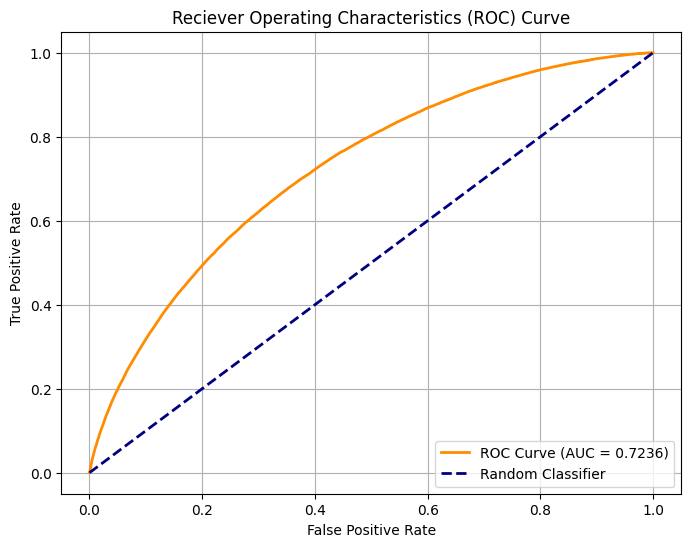

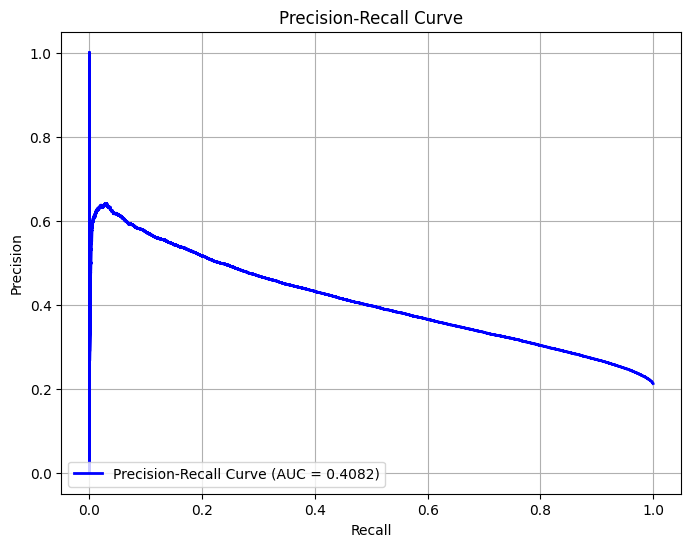

In [26]:
from sklearn.metrics import auc # should have been done at the start

print("\n--- Evaluating Logistics Regression Model Performance ---")
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_lr)) # Accuracy
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr)) # Confusion Matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr)) # Classification Report

# ROC AUC Score (this is another metric for testing performance, the higher the AUC score, the better (0 - 1))
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Reciever Operating Characteristics (ROC) Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Adding a Precision recall curve, this useful for imbalanced data, which this data set most definitely was
precision, recall, _ = precision_recall_curve(y_test, y_prob_lr)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## Analysis of Logistic Regression Model Performance

**Overall Accuracy: 65.60%**

The overall accuracy indicates that the model correctly classified approximately 65.60% of the instances in the test set. While accuracy provides a general measure of correctness, it can be misleading in the context of highly imbalanced datasets, as a high accuracy can be achieved by simply predicting the majority class for all instances. Given the class distribution in the test set (approximately 78.8% non-default), the observed accuracy is below this baseline, suggesting the model is attempting to classify both classes.

**Confusion Matrix:**

The confusion matrix provides a detailed breakdown of the model's predictions versus the actual outcomes:
[[140555 75193] [ 19022 39144]]


*   **True Negatives (TN): 140,555** - Instances correctly predicted as Class 0 (Non-Default).
*   **False Positives (FP): 75,193** - Instances incorrectly predicted as Class 1 (Default) when they were actually Class 0. These represent Type I errors (false alarms).
*   **False Negatives (FN): 19,022** - Instances incorrectly predicted as Class 0 (Non-Default) when they were actually Class 1. These represent Type II errors (missed defaults), which are particularly critical in credit risk assessment.
*   **True Positives (TP): 39,144** - Instances correctly predicted as Class 1 (Default).

**Classification Report:**

The classification report provides key metrics (Precision, Recall, F1-score) for each class:

*   **True Negatives (TN): 140,555** - Instances correctly predicted as Class 0 (Non-Default).
*   **False Positives (FP): 75,193** - Instances incorrectly predicted as Class 1 (Default) when they were actually Class 0. These represent Type I errors (false alarms).
*   **False Negatives (FN): 19,022** - Instances incorrectly predicted as Class 0 (Non-Default) when they were actually Class 1. These represent Type II errors (missed defaults), which are particularly critical in credit risk assessment.
*   **True Positives (TP): 39,144** - Instances correctly predicted as Class 1 (Default).

**Classification Report:**

The classification report provides key metrics (Precision, Recall, F1-score) for each class:
           precision    recall  f1-score   support

       0       0.88      0.65      0.75    215748
       1       0.34      0.67      0.45     58166

accuracy                           0.66    273914
macro avg 0.61 0.66 0.60 273914 
weighted avg 0.77 0.66 0.69 273914


*   **Class 0 (Non-Default):**
    *   **Precision (0.88):** Of all instances predicted as Non-Default, 88% were actually Non-Default. This indicates high reliability when predicting the majority class.
    *   **Recall (0.65):** The model correctly identified 65% of all actual Non-Default instances.
    *   **F1-score (0.75):** The harmonic mean of precision and recall for Class 0, indicating a good balance for the majority class.
*   **Class 1 (Default):**
    *   **Precision (0.34):** Of all instances predicted as Default, only 34% were actually Default. This low precision highlights a significant number of false positive predictions for the minority class.
    *   **Recall (0.67):** The model correctly identified 67% of all actual Default instances. This indicates a reasonable ability to capture the minority class instances.
    *   **F1-score (0.45):** The F1-score for Class 1 is considerably lower than for Class 0, reflecting the trade-off between precision and recall for the minority class.

**ROC AUC Score: 0.7236**

The ROC AUC score quantifies the model's ability to discriminate between the positive (Default) and negative (Non-Default) classes across various classification thresholds. A score of 0.5 indicates random chance, while 1.0 indicates perfect discrimination. An AUC of 0.7236 suggests that the model has moderate discriminatory power, performing better than random chance but indicating substantial room for improvement in separating the two classes.

**Conclusion:**

The Logistic Regression model demonstrates a typical performance profile for a model trained with oversampling on an imbalanced dataset and evaluated on the original distribution. It exhibits strong performance on the majority class (Non-Default) in terms of precision. For the minority class (Default), the model achieves a reasonable recall (identifying 67% of actual defaults) but suffers from low precision (only 34% of predicted defaults are correct), resulting in a high rate of false positives. The ROC AUC score confirms the model's moderate ability to distinguish between the classes. Future efforts should focus on improving the precision for the default class while maintaining or improving recall, potentially through exploring different models, feature engineering, or cost-sensitive learning techniques.